Commented a bunch of stuff out to speed up


In [2]:
import glob
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from IPython.display import display
from skforecast.plot import set_dark_theme
from tqdm import tqdm

import sklearn
import skforecast
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from skforecast.recursive import ForecasterRecursive, ForecasterRecursiveMultiSeries
from skforecast.model_selection import (
    TimeSeriesFold,
    OneStepAheadFold,
    backtesting_forecaster,
    bayesian_search_forecaster,
    backtesting_forecaster_multiseries,
    bayesian_search_forecaster_multiseries
)
from skforecast.preprocessing import RollingFeatures, series_long_to_dict, exog_long_to_dict
from skforecast.exceptions import OneStepAheadValidationWarning

import warnings

warnings.filterwarnings("ignore", category=ResourceWarning)

colourOrangeBold = "\033[1m\033[38;5;208m"
colourReset = "\033[0m"

print(f"{colourOrangeBold}Version skforecast: {skforecast.__version__}{colourReset}")
print(f"{colourOrangeBold}Version scikit-learn: {sklearn.__version__}{colourReset}")
print(f"{colourOrangeBold}Version pandas: {pd.__version__}{colourReset}")
print(f"{colourOrangeBold}Version numpy: {np.__version__}{colourReset}")

import os
from pathlib import Path

project_root = Path().resolve()
while project_root.name != "Algothon-2025" and project_root != project_root.parent:
    project_root = project_root.parent

os.chdir(project_root)
print("Working directory set to:", os.getcwd())

set_dark_theme()

Version skforecast: 0.16.0
Version scikit-learn: 1.6.1
Version pandas: 2.2.3
Version numpy: 2.2.5
Working directory set to: C:\Users\jense\IdeaProjects\Algothon-2025


Set Training, Cross Validation and Testing Splits

In [4]:
TRAIN_START = 20
TRAIN_END = 600
VAL_END = 675

Import our price data: Prices are what we are predicting

In [5]:
# PRICES DATA:
data = pd.read_csv("./sourceCode/prices.txt", sep=r'\s+', header=None)
print(f"{colourOrangeBold}Shape: {data.shape}{colourReset}")

Shape: (750, 50)


Add column names to prices data

In [6]:
data.index.name = 'day'
data.columns = [f"inst_{i}" for i in range(data.shape[1])]

Split data into correct splits

In [7]:
# DATA SPLITTING:
data_train = data.loc[TRAIN_START:TRAIN_END - 1].copy()
data_val   = data.loc[TRAIN_END:VAL_END - 1].copy()
data_test  = data.loc[VAL_END:].copy()

print(f"Train days      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation days : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test days       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train days      : 20 --- 599  (n=580)
Validation days : 600 --- 674  (n=75)
Test days       : 675 --- 749  (n=75)


Plot prices data for a few instruments for fun

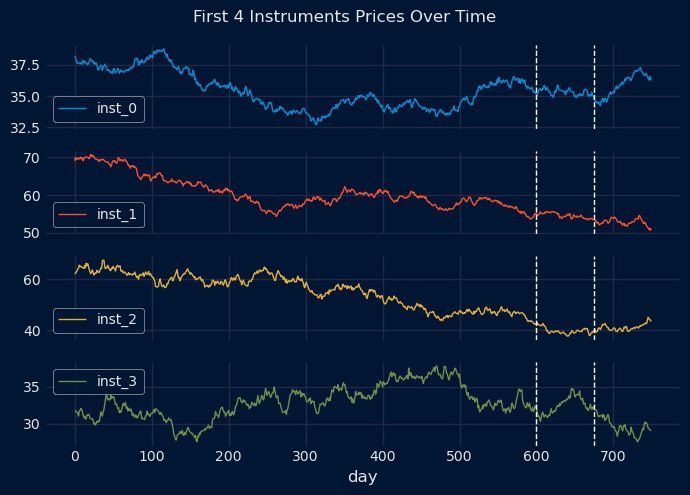

In [8]:
instrumentCount = 4

fig, axs = plt.subplots(instrumentCount, 1, figsize=(7, 5), sharex=True)
data.iloc[:, :instrumentCount].plot(
    legend=True,
    subplots=True,
    title='First 4 Instruments Prices Over Time',
    ax=axs,
    linewidth=1
)
# Add vertical lines at training and validation split
for ax in axs:
    ax.axvline(x=TRAIN_END, color='white', linestyle='--', linewidth=1)
    ax.axvline(x=VAL_END, color='white', linestyle='--', linewidth=1)
fig.tight_layout()
plt.show()

Train a forecaster that predicts prices for individual instruments for a baseline reference.

In [ ]:
items = []
mse_values = []
predictions = {}

for i, item in enumerate(tqdm(data.columns)):
    # Define forecaster
    window_features = RollingFeatures(stats=['mean', 'min', 'max'], window_sizes=7)

    forecaster = ForecasterRecursive(
        regressor=HistGradientBoostingRegressor(random_state=8523),
        lags=20,
        window_features=window_features
    )

    # Backtesting forecaster
    cv = TimeSeriesFold(
        steps=1,
        initial_train_size=len(data_train) + len(data_val),
        refit=False,
    )

    metric, preds = backtesting_forecaster(
        forecaster=forecaster,
        y=data[item],
        cv=cv,
        metric='mean_squared_error',
        show_progress=False
    )

    items.append(item)
    mse_values.append(metric.at[0, 'mean_squared_error'])
    predictions[item] = preds

# Results
uni_series_mse = pd.Series(
    data=mse_values,
    index=items,
    name='uni_series_mse'
)

print(f"{colourOrangeBold}========================{colourReset}")
print(uni_series_mse.head())
print(f"{colourOrangeBold}========================{colourReset}\n\n")


Train a global / multi time series predictor that takes into account instrument correlation (Evaluated with the same backtester as the single instrument predictor):

In [ ]:
items = list(data.columns)

# Define forecaster
window_features = RollingFeatures(stats=['mean', 'min', 'max'], window_sizes=14)
forecaster_ms = ForecasterRecursiveMultiSeries(
    regressor           =GradientBoostingRegressor(random_state=8523), # ~ 20 seconds
    # regressor           =HistGradientBoostingRegressor(random_state=8523), # Much quicker, slightly less accurate, nan safe
    lags                =20,
    encoding            ='ordinal',
    transformer_series  =StandardScaler(),
    window_features     =window_features,
)

# Backtesting forecaster for all items
cv = TimeSeriesFold(
    initial_train_size  =len(data_train) + len(data_val),
    steps               =1,   # Predict 7 steps ahead
    refit               =True # Retrain at each split
)

multi_series_mse, predictions_ms = backtesting_forecaster_multiseries(
    forecaster          =forecaster_ms,
    series              =data,
    levels              =items,
    cv                  =cv,
    metric              ='mean_squared_error',
)

# Results
display(multi_series_mse.head(5))
display(predictions_ms.head(5))

predictions_ms = predictions_ms.reset_index()

Compare the global to unique predictors:

In [ ]:
multi_series_mse = multi_series_mse.set_index('levels')
multi_series_mse.columns = ['multi_series_mse']

results = pd.concat((uni_series_mse, multi_series_mse), axis=1)
results['improvement'] = results.eval('uni_series_mse - multi_series_mse')
results['improvement_(%)'] = 100 * results.eval('(uni_series_mse - multi_series_mse) / uni_series_mse')
results = results.round(2)

display(results.style.bar(subset=['improvement_(%)'], align='mid', color=['#d65f5f', '#5fba7d']))
display(results[['improvement', 'improvement_(%)']].agg(['mean', 'min', 'max']))


Using global predict:

In [ ]:
def plotPredictedVsActual(predictions_input, instrument):
    df_preds = predictions_input.copy().rename(columns={"index": "time"})
    df_inst_preds = df_preds[df_preds["level"] == instrument]
    days_predicted = df_inst_preds["time"]
    df_actual = data[[instrument]].copy()
    df_actual["time"] = df_actual.index
    df_actual = df_actual.rename(columns={instrument: "actual"})
    df_actual = df_actual[df_actual["time"].isin(days_predicted)]
    df_plot = df_inst_preds.merge(df_actual, on="time")
    display(df_plot)
    # Step 4: Plot
    plt.figure(figsize=(12, 5))
    plt.plot(df_plot["time"], df_plot["actual"], label="Actual Price", color='dodgerblue')
    plt.plot(df_plot["time"], df_plot["pred"], label="Predicted Price", color='orange')
    plt.title(f"Predicted vs Actual Prices for {instrument}")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.show()


plotPredictedVsActual(predictions_ms, "inst_0")


Above looks decent but also a bit shite

**Now going to try adding more greeks to use in the model as exogenous features**


In [ ]:
# Get exog features in a dictionary
greeksFilePaths = sorted(glob.glob("./greeks/greeksData_750Days/*.npy"))
feature_names = [os.path.splitext(os.path.basename(f))[0] for f in greeksFilePaths]

exog_array = np.stack([np.load(f) for f in greeksFilePaths], axis=-1)

exog_dict = {
    f"inst_{i}": pd.DataFrame(exog_array[:, i, :], columns=feature_names)
    for i in range(exog_array.shape[1])
}

print(f"{colourOrangeBold}Built exog_dict with {len(exog_dict)} instruments, each shape {exog_dict['inst_0'].shape}{colourReset}")
print("Features:", feature_names)

Create our forecaster including these exogenous features


In [ ]:
forecaster_ms_greeks = ForecasterRecursiveMultiSeries(
    regressor           = GradientBoostingRegressor(random_state=8523),
    lags                = 20,
    transformer_series  = StandardScaler(),
    transformer_exog    = StandardScaler(),  # Standardise the Greek features
)

cv = TimeSeriesFold(
    initial_train_size = len(data_train) + len(data_val),
    steps              = 1,
    refit              = True
)

# Backtest
multi_series_mse_greeks, predictions_ms_greeks = backtesting_forecaster_multiseries(
    forecaster = forecaster_ms_greeks,
    series     = data,
    exog       = exog_dict,
    levels     = list(data.columns),
    cv         = cv,
    metric     = "mean_squared_error"
)

display(multi_series_mse_greeks.head())
display(predictions_ms_greeks.head())

multi_series_mse_greeks = multi_series_mse_greeks.rename(columns={"mean_squared_error": "multi_series_mse_greeks"})
predictions_ms_greeks = predictions_ms_greeks.reset_index()
predictions_ms_greeks = predictions_ms_greeks.rename(columns={"index": "time"})

Compare new predictions and plot new predictions vs Actual

In [ ]:
multi_series_mse_greeks = multi_series_mse_greeks.set_index("levels")
# Join them
results_greeks = pd.concat((multi_series_mse, multi_series_mse_greeks), axis=1)

# Calculate improvements
results_greeks['improvement'] = results_greeks.eval('multi_series_mse - multi_series_mse_greeks')
results_greeks['improvement_(%)'] = 100 * results_greeks['improvement'] / results_greeks['multi_series_mse']
results_greeks = results_greeks.round(2)

# Display the goods
display(results_greeks.style.bar(subset=['improvement_(%)'], align='mid', color=['#d65f5f', '#5fba7d']))
display(results_greeks[['improvement', 'improvement_(%)']].agg(['mean', 'min', 'max']))

In [ ]:
plotPredictedVsActual(predictions_ms_greeks, "inst_0")

# Now to try and predict log returns instead of prices:

In [9]:
logReturns_np = np.load("./greeks/greeksData_750Days/LogReturns_lookback=1_750_day_data.npy")
logReturns = pd.DataFrame(logReturns_np)

logReturns.columns = [f"inst_{i}" for i in range(logReturns.shape[1])]

print(f"{colourOrangeBold}Log returns shape = {colourReset}{logReturns.shape}")

Log returns shape = (750, 50)


Create exogenous data (now with prices, laggedPrices and without logReturns (logReturns is used in predictions by lag))

In [10]:
all_paths = sorted(glob.glob("./greeks/greeksData_750Days/*.npy"))

feature_paths = [
    p for p in all_paths
    if 'LogReturns' not in os.path.basename(p)
]

feature_names = [
    os.path.splitext(os.path.basename(p))[0]
    for p in feature_paths
]

exog_array = np.stack([np.load(p) for p in feature_paths], axis=-1)

price_array = data.to_numpy()
exog_array_with_price = np.concatenate(
    [exog_array, price_array[:, :, np.newaxis]],
    axis=-1
)
feature_names.append("price")

exog_dict_for_logReturns = {
    f"inst_{i}": pd.DataFrame(
        exog_array_with_price[:, i, :],
        columns=feature_names
    )
    for i in range(exog_array_with_price.shape[1])
}

print(f"Built exog_dict_for_logReturns with {len(exog_dict_for_logReturns)} instruments, each shape {exog_dict_for_logReturns['inst_0'].shape}")
print("Features:", feature_names)

Built exog_dict_for_logReturns with 50 instruments, each shape (750, 12)
Features: ['LaggedPrices_Lag=1_750_day_data', 'LaggedPrices_Lag=2_750_day_data', 'LaggedPrices_Lag=3_750_day_data', 'LaggedPrices_Lag=4_750_day_data', 'LaggedPrices_Lag=5_750_day_data', 'Momentum_windowSize=14_750_day_data', 'Momentum_windowSize=3_750_day_data', 'Momentum_windowSize=7_750_day_data', 'Volatility_windowSize=10_750_day_data', 'Volatility_windowSize=20_750_day_data', 'Volatility_windowSize=5_750_day_data', 'price']


Now split our data

In [ ]:
logReturns_train = data.loc[TRAIN_START:TRAIN_END - 1].copy()
logReturns_val   = data.loc[TRAIN_END:VAL_END - 1].copy()
logReturns_test  = data.loc[VAL_END:].copy()

print(f"Train days      : {logReturns_train.index.min()} --- {logReturns_train.index.max()}  (n={len(logReturns_train)})")
print(f"Validation days : {logReturns_val.index.min()} --- {logReturns_val.index.max()}  (n={len(logReturns_val)})")
print(f"Test days       : {logReturns_test.index.min()} --- {logReturns_test.index.max()}  (n={len(logReturns_test)})")

Now create this prediction model

In [ ]:
forecaster_ms_greeks_logReturns = ForecasterRecursiveMultiSeries(
    regressor           = GradientBoostingRegressor(random_state=8523),
    lags                = 20,
    transformer_series  = None,
    transformer_exog    = StandardScaler(),  # Standardise the Greek features
)

cv = TimeSeriesFold(
    initial_train_size = len(logReturns_train) + len(logReturns_val),
    steps              = 1,
    refit              = True
)

# Backtest
multi_series_mse_greeks_logReturns, predictions_ms_greeks_logReturns = backtesting_forecaster_multiseries(
    forecaster = forecaster_ms_greeks_logReturns,
    series     = logReturns,
    exog       = exog_dict_for_logReturns,
    levels     = list(logReturns.columns),
    cv         = cv,
    metric     = "mean_squared_error"
)

display(multi_series_mse_greeks_logReturns.head())
display(predictions_ms_greeks_logReturns.head())

multi_series_mse_greeks_logReturns = multi_series_mse_greeks_logReturns.rename(columns={"mean_squared_error": "multi_series_mse_greeks_logReturns"})
predictions_ms_greeks_logReturns = predictions_ms_greeks_logReturns.reset_index()
predictions_ms_greeks_logReturns = predictions_ms_greeks_logReturns.rename(columns={"index": "time"})

print(f"{colourOrangeBold} Average MSE across instruments: {multi_series_mse_greeks_logReturns['multi_series_mse_greeks_logReturns'].mean()}")

And now plot our predicted log returns against the actual:

In [ ]:
def plotPredictedVsActualLogReturns(predictions_input, instrument):
    df_preds = predictions_input.copy().rename(columns={"index": "time"})
    df_inst_preds = df_preds[df_preds["level"] == instrument]
    days_predicted = df_inst_preds["time"]
    df_actual = logReturns[[instrument]].copy()
    df_actual["time"] = df_actual.index
    df_actual = df_actual.rename(columns={instrument: "actual"})
    df_actual = df_actual[df_actual["time"].isin(days_predicted)]
    df_plot = df_inst_preds.merge(df_actual, on="time")

    plt.figure(figsize=(12, 5))
    plt.plot(df_plot["time"], df_plot["actual"], label="Actual LogReturn", color='dodgerblue')
    plt.plot(df_plot["time"], df_plot["pred"], label="Predicted LogReturn", color='orange')
    plt.title(f"Predicted vs Actual LogReturns for {instrument}")
    plt.xlabel("Time")
    plt.ylabel("Log Return")
    plt.legend()
    plt.grid(True)
    plt.show()

plotPredictedVsActualLogReturns(predictions_ms_greeks_logReturns, "inst_0")

 We will consider this an optimal result for prediction and a baseline for future reference

Convert predicted log returns to be the predicted next price. We can then compare this logReturns predicting model against our pricePredicting model/s

In [ ]:
price_predict_from_logReturns = predictions_ms_greeks_logReturns.copy()

# Rename predicted log return column temporarily
price_predict_from_logReturns = price_predict_from_logReturns.rename(columns={"pred": "predicted_logReturn"})

# Reconstruct predicted price using previous day's actual price
def reconstruct_price(row):
    instrument = row['level']
    time = row['time']
    if time == 0:
        return np.nan  # Can't compute for first day
    prev_price = data.loc[time - 1, instrument]
    log_return = row['predicted_logReturn']
    return prev_price * np.exp(log_return)

# Apply the function to reconstruct price
price_predict_from_logReturns["pred"] = price_predict_from_logReturns.apply(reconstruct_price, axis=1)

# Drop the original log return prediction
price_predict_from_logReturns = price_predict_from_logReturns.drop(columns=["predicted_logReturn"])

display(price_predict_from_logReturns)

Compare

In [ ]:
from sklearn.metrics import mean_squared_error

# Add actual prices from your price DataFrame (`data`)
price_predict_from_logReturns["actual"] = price_predict_from_logReturns.apply(
    lambda row: data.loc[row["time"], row["level"]],
    axis=1
)

predictions_ms_greeks["actual"] = predictions_ms_greeks.apply(
    lambda row: data.loc[row["time"], row["level"]],
    axis=1
)

mse_logReturns = price_predict_from_logReturns.groupby("level", group_keys=False).apply(
    lambda g: mean_squared_error(g["actual"], g["pred"]),
    include_groups=False
).reset_index(name="mse_logReturns")

mse_greeks = predictions_ms_greeks.groupby("level", group_keys=False).apply(
    lambda g: mean_squared_error(g["actual"], g["pred"]),
    include_groups=False
).reset_index(name="mse_greeks")

# Merge and compute improvements
mse_comparison = pd.merge(mse_logReturns, mse_greeks, on="level")
mse_comparison["improvement"] = mse_comparison["mse_greeks"] - mse_comparison["mse_logReturns"]
mse_comparison["improvement_(%)"] = 100 * mse_comparison["improvement"] / mse_comparison["mse_logReturns"]
mse_comparison = mse_comparison.round(4)

# Style output
display(mse_comparison.set_index("level").style.bar(
    subset=["improvement_(%)"], align="mid", color=["#d65f5f", "#5fba7d"]
))

# Summary stats
display(mse_comparison[["improvement", "improvement_(%)"]].agg(["mean", "min", "max"]))


Mostly big improvements from predicting prices to predicting log returns.


Having the model retrain every time will exceed the 10 minute running length in the competition, we need to modify. A few options:
- Change the regressor to HistGradientBoostingRegressor
- Turn off refit
- Somehow change refit to not refit everytime but instead every nth time

HIST GRADIENT BOOSTING:

In [ ]:
forecaster_ms_greeks_logReturns_hgbr = ForecasterRecursiveMultiSeries(
    regressor           = HistGradientBoostingRegressor(random_state=8523),
    lags                = 20,
    transformer_series  = None,
    transformer_exog    = StandardScaler(),  # Standardise the Greek features
)

cv = TimeSeriesFold(
    initial_train_size = len(logReturns_train) + len(logReturns_val),
    steps              = 1,
    refit              = True
)

# Backtest
multi_series_mse_greeks_logReturns_hgbr, predictions_ms_greeks_logReturns_hgbr = backtesting_forecaster_multiseries(
    forecaster = forecaster_ms_greeks_logReturns_hgbr,
    series     = logReturns,
    exog       = exog_dict_for_logReturns,
    levels     = list(logReturns.columns),
    cv         = cv,
    metric     = "mean_squared_error"
)

display(multi_series_mse_greeks_logReturns_hgbr.head())
display(predictions_ms_greeks_logReturns_hgbr.head())

multi_series_mse_greeks_logReturns_hgbr = multi_series_mse_greeks_logReturns_hgbr.rename(columns={"mean_squared_error": "multi_series_mse_greeks_logReturns_hgbr"})
predictions_ms_greeks_logReturns_hgbr = predictions_ms_greeks_logReturns_hgbr.reset_index()
predictions_ms_greeks_logReturns_hgbr = predictions_ms_greeks_logReturns_hgbr.rename(columns={"index": "time"})

print(f"{colourOrangeBold} Average MSE across instruments: { multi_series_mse_greeks_logReturns_hgbr['multi_series_mse_greeks_logReturns_hgbr'].mean()}")

Compare HGBR to GBR (just using their log returns mse from now on because we will be predicting log returns)
:

In [ ]:
def compareModelToBaseline(new_model_mse, baselineModel = multi_series_mse_greeks_logReturns_hgbr):
    # Join them
    results = pd.merge(
        baselineModel,
        new_model_mse,
        on="levels",
    )

    # Rename for clarity
    results.columns = ["level", "BASELINE_MSE", "NEW_MSE"]

    # Calculate improvement of new over GBR
    results["improvement"] = results["BASELINE_MSE"] - results["NEW_MSE"]
    results["improvement_(%)"] = 100 * results["improvement"] / results["BASELINE_MSE"]

    # Round and display
    results = results.round(4)
    display(results.style.bar(subset=['improvement_(%)'], align='mid', color=['#d65f5f', '#5fba7d']))
    display(results[['improvement', 'improvement_(%)']].agg(['mean', 'min', 'max']))

compareModelToBaseline(multi_series_mse_greeks_logReturns_hgbr, multi_series_mse_greeks_logReturns)

For some reason the HGBR is better than the GBR so lets use that as our new baseline


In [ ]:
print("HGBR:")
plotPredictedVsActualLogReturns(predictions_ms_greeks_logReturns_hgbr, "inst_0")
print("GBR:")
plotPredictedVsActualLogReturns(predictions_ms_greeks_logReturns, "inst_0")

Now a model without refit

In [ ]:
forecaster_ms_greeks_logReturns = ForecasterRecursiveMultiSeries(
    regressor           = GradientBoostingRegressor(random_state=8523),
    lags                = 20,
    transformer_series  = None,
    transformer_exog    = StandardScaler(),  # Standardise the Greek features
)

cv = TimeSeriesFold(
    initial_train_size = len(logReturns_train) + len(logReturns_val),
    steps              = 1,
    refit              = False
)

# Backtest
multi_series_mse_greeks_logReturns_noRefit, predictions_ms_greeks_logReturns_noRefit = backtesting_forecaster_multiseries(
    forecaster = forecaster_ms_greeks_logReturns,
    series     = logReturns,
    exog       = exog_dict_for_logReturns,
    levels     = list(logReturns.columns),
    cv         = cv,
    metric     = "mean_squared_error"
)

display(multi_series_mse_greeks_logReturns_noRefit.head())
display(predictions_ms_greeks_logReturns_noRefit.head())

multi_series_mse_greeks_logReturns_noRefit = multi_series_mse_greeks_logReturns_noRefit.rename(columns={"mean_squared_error": "multi_series_mse_greeks_logReturns_noRefit"})
predictions_ms_greeks_logReturns_noRefit = predictions_ms_greeks_logReturns_noRefit.reset_index()
predictions_ms_greeks_logReturns_noRefit = predictions_ms_greeks_logReturns_noRefit.rename(columns={"index": "time"})

print(f"{colourOrangeBold} Average MSE across instruments: {multi_series_mse_greeks_logReturns_noRefit['multi_series_mse_greeks_logReturns_noRefit'].mean()}")

Compare this to the best model:

In [ ]:
print("Comparing new model of 'GBR no refit' VS 'HGBR with refit'")
compareModelToBaseline(multi_series_mse_greeks_logReturns_noRefit, multi_series_mse_greeks_logReturns_hgbr)

Ok so its clear then that we should use HGBR as our primary choice. Now time for:

Adding some rolling window features
Allowed stats are:
- mean
- std
- min
- max
- sum
- median
- ratio_min_max
- coef_variation
- ewm

In [ ]:
from sklearn.preprocessing import MinMaxScaler

window_features = RollingFeatures(
    stats           = ['min', 'max'],
    window_sizes    = 10,
)

window_features_forecaster = ForecasterRecursiveMultiSeries(
    regressor = HistGradientBoostingRegressor(random_state=8523),
    transformer_series  = None,
    transformer_exog    = StandardScaler(),
    lags                = 20,
    window_features     = window_features,
)

window_features_forecaster.dropna_from_series = True

cv = TimeSeriesFold(
    initial_train_size  =len(logReturns_train) + len(logReturns_val),
    steps               =1,
    refit               =True
)

multi_series_mse_window, predictions_tuned_window = backtesting_forecaster_multiseries(
    forecaster  = window_features_forecaster,
    series      = logReturns,
    exog        = exog_dict_for_logReturns,
    levels      = list(logReturns.columns),
    cv          = cv,
    metric      = 'mean_squared_error',
)

multi_series_mse_window = multi_series_mse_window.rename(columns={"mean_squared_error": "multi_series_mse_window"})
predictions_tuned_window = predictions_tuned_window.reset_index()
predictions_tuned_window = predictions_tuned_window.rename(columns={"index": "time"})

print("Window features: ", window_features.stats)
print("Window length:   ", window_features.window_sizes)
print(
    f"{colourOrangeBold} Average MSE across instruments: {multi_series_mse_window['multi_series_mse_window'].mean()}")


### Ive tried a bunch of different combos, just min and max is the best.

Also tried different scaler combinations. The best is
series transformer = None
exog transformer =  StandardScaler()

Compare this to our baseline HGBR:

In [ ]:
print("Comparing new model of 'GBR with window' VS 'HGBR with refit'")
compareModelToBaseline(multi_series_mse_window, multi_series_mse_greeks_logReturns_hgbr)

# HyperParameterTuning

### To get the most out of our model, tune the params.

Params to tune:
- Lags
- Learning Rate
- max_depth (max depth of tree in the ensemble) # Decided to not do
- max_iter (number of trees in the ensemble) # Decided to not do

In [ ]:
def search_space(trial):
    return {
        'lags': trial.suggest_categorical('lags', [7, 14]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
    }

In [ ]:
window_features = RollingFeatures(
    stats           = ['min', 'max'],
    window_sizes    = 10,
)

forecaster_ms_tuning = ForecasterRecursiveMultiSeries(
    regressor           = HistGradientBoostingRegressor(random_state=8523),
    lags                = 20, # Should be overwritten by the search space
    transformer_exog    = StandardScaler(),
    transformer_series  = None,
    encoding            = 'ordinal',
    window_features     = window_features,
)

cv_search = TimeSeriesFold(
    initial_train_size  = len(logReturns_train) + len(logReturns_val),
    steps               = 1,
    refit               = False
)

In [ ]:
# For bayesian search we need to change the shape of our exogs
def flatten_exog_dict_to_wide_df(exog_dict):
    dfs = []
    for level, df in exog_dict.items():
        renamed = df.copy()
        renamed.columns = [f"{level}__{col}" for col in df.columns]
        dfs.append(renamed)

    # All have same number of rows, so just concat by columns
    return pd.concat(dfs, axis=1)

# Apply it
exog_wide = flatten_exog_dict_to_wide_df(exog_dict_for_logReturns)
print("exog_wide.shape:", exog_wide.shape)  # Should be (750, many columns)


#### Bayesian search for hyper param tuning


In [ ]:
from skforecast.model_selection import bayesian_search_forecaster_multiseries
from skforecast.exceptions import OneStepAheadValidationWarning
from skforecast.exceptions import MissingValuesWarning
import warnings

warnings.simplefilter("ignore", category=OneStepAheadValidationWarning)
warnings.simplefilter("ignore", category=MissingValuesWarning)
forecaster_ms_tuning.dropna_from_series = True

results_df, best_trial = bayesian_search_forecaster_multiseries(
    forecaster      = forecaster_ms_tuning,
    series          = logReturns,
    levels          = None,  # All instruments
    exog            = exog_wide,
    cv              = cv_search,
    search_space    = search_space,
    n_trials        = 40,
    metric          = 'mean_squared_error',
    return_best     = True, # results_df will contain the best fitting forecaster, params and metrics.
    show_progress   = True,
)

best_idx = results_df['mean_squared_error__average'].idxmin()
best_row = results_df.loc[best_idx]

print("Best Trial Index:", best_idx)
print("Best Params:", best_row['params'])
print("Best Lags:", best_row['lags'])
print("Best MSE:", best_row['mean_squared_error__average'])

In [ ]:
best_params = best_row['params']
best_lags = best_row['lags']


window_features = RollingFeatures(
    stats           = ['min', 'max'],
    window_sizes    = 10,
)
best_forecaster = ForecasterRecursiveMultiSeries(
    regressor           = HistGradientBoostingRegressor(random_state=8523, **best_params),
    transformer_series  = None,
    transformer_exog    = StandardScaler(),
    lags                = best_lags,
    window_features     = window_features,
)

best_forecaster.dropna_from_series = True

cv = TimeSeriesFold(
    initial_train_size  = len(logReturns_train) + len(logReturns_val),
    steps               = 1,
    refit               = True
)

multi_series_mse_tuned, predictions_tuned = backtesting_forecaster_multiseries(
    forecaster  = best_forecaster,
    series      = logReturns,
    exog        = exog_dict_for_logReturns,
    levels      = list(logReturns.columns),
    cv          = cv,
    metric      = 'mean_squared_error',
)

multi_series_mse_tuned = multi_series_mse_tuned.rename(columns={"mean_squared_error": "multi_series_mse_tuned"})
predictions_tuned = predictions_tuned.reset_index()
predictions_tuned = predictions_tuned.rename(columns={"index": "time"})

print(f"{colourOrangeBold} Average MSE across instruments: {multi_series_mse_tuned['multi_series_mse_tuned'].mean()}{colourOrangeBold}")


Now compare against our benchmark:

In [ ]:
compareModelToBaseline(multi_series_mse_tuned, multi_series_mse_window)

On average better by a tad but not really that much.  =

Plot predicted log returns against actual (and our benchmark too):

In [ ]:
plotPredictedVsActualLogReturns(predictions_tuned, "inst_0")
plotPredictedVsActualLogReturns(predictions_ms_greeks_logReturns_hgbr, "inst_0")

Cant really tell a difference

Save our best params to a file:

In [ ]:
import joblib
from datetime import datetime

best_forecaster.fit(
    series  = logReturns,   # Train the forecaster on all of our data
    exog    = exog_dict_for_logReturns,
)

fitted_scaler = best_forecaster.transformer_exog    # Save our fitted scaler


model_package = {
    "forecaster": best_forecaster,
    "best_params": best_params,
    "best_lags": best_lags,
    "window_features": window_features,
    "transformer_exog": fitted_scaler,
    "feature_names": exog_dict_for_logReturns["inst_0"].columns.tolist(),
}

now = datetime.now()
timestamp = now.strftime("date-%Y-%m-%d_time-%H-%M-%S")
filepath = f"./saved models/forecaster_model_{timestamp}.pkl"

# Save to file
joblib.dump(
    model_package,
    filepath,
)

Some ideas:
- Predict vol over an n window and then steps = n as well to have a predictor of future volatilities of instruments for risk
- Predict log returns with step 2 together with step 1. then if they oppose say next log return is > 0, and the one after is < 0, might be a bad idea to buy because of the trading tax or something